In [1]:
import ast
import pandas as pd
import numpy as np
import os
from time import ctime
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows=300
%matplotlib inline

### start from here

In [2]:
import ast
import pandas as pd
import numpy as np
import os
from time import ctime
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows=300
%matplotlib inline

In [3]:
%%time
df_skills = pd.read_csv('./skills.golden.train.csv')
df_skills = df_skills.set_index('user_id')
print df_skills.shape

(102514, 1040)
CPU times: user 5.56 s, sys: 979 ms, total: 6.54 s
Wall time: 6.57 s


In [4]:
df_skills = df_skills.fillna(0)
df_skills = df_skills.astype(int)

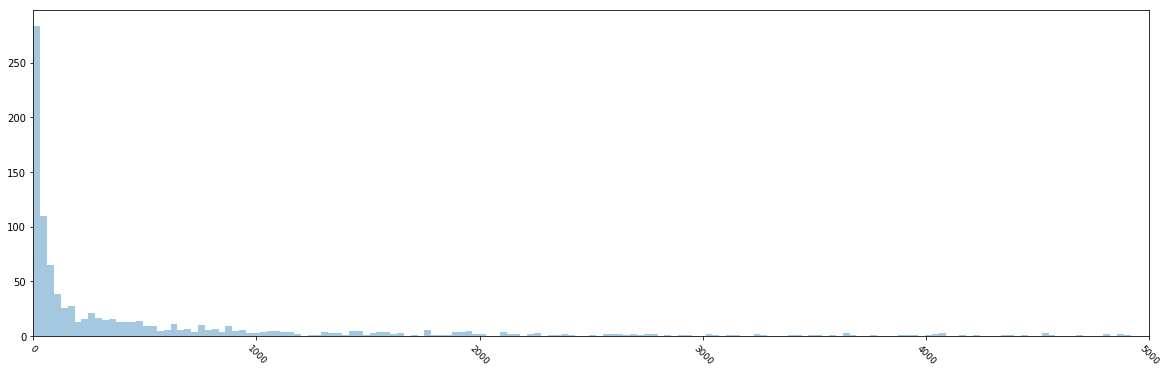

In [5]:
plt.figure(figsize=(20,6))
ax = sns.distplot(df_skills.sum(), bins=1000, kde=False)
plt.ylim(0, None)
plt.xlim(0, 5000)
# ax.xaxis.set_ticks(np.arange(0, 501, 10))
ax.xaxis.set_tick_params(labelsize=9, rotation=-45)

In [6]:
(df_skills.sum()==1).sum()

33

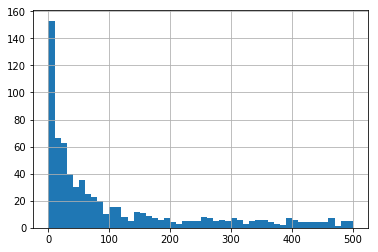

In [7]:
df_skills.sum().hist(bins=50, range=[0, 500], lw=1)

In [12]:
(df_skills.sum()<=10).sum()

159

In [14]:
df_skills.sum().describe()

count     1040.000000
mean      1129.413462
std       2926.021813
min          1.000000
25%         25.000000
50%        149.500000
75%        816.750000
max      30731.000000
dtype: float64

In [15]:
(df_skills.sum()<100).sum()

465

In [16]:
(df_skills.sum()<10).sum()

153

In [17]:
df_skills.sum()[(df_skills.sum()<10)].index

Index([u'Antenna Services', u'Roofing', u'Flask', u'Decking', u'Lighting',
       u'Oculus Rift', u'Pet Sitting', u'Commercial Cleaning', u'Yiddish',
       u'Google Cardboard',
       ...
       u'Flooring', u'Apple Compressor', u'Apache Maven', u'Agronomy',
       u'Microsoft Hololens', u'Equipment Hire', u'Netbeans', u'Paytrace',
       u'Autodesk Sketchbook Pro', u'Virtualization'],
      dtype='object', length=153)

In [18]:
delete_10 = df_skills.sum()[(df_skills.sum()<10)].index
len(delete_10)

153

In [19]:
df_skills_V1 = df_skills.drop(delete_10, axis=1)
df_skills_V1.shape

(102514, 887)

In [30]:
df = pd.read_csv('./Training_set.csv')
df = df.set_index('user_id')
df.shape

(108011, 2)

In [32]:
df_skills_V1_pre = df[['label']].join(df_skills_V1, how='inner')
df_skills_V1_pre.shape

(102514, 888)

### model

In [33]:
from parseHelper import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools

In [34]:
y=df_skills_V1_pre.pop('label')

from sklearn.model_selection import train_test_split
dim=lambda *x: [i.shape for i in x]
X_train, X_test, y_train, y_test = train_test_split(df_skills_V1_pre, y, test_size=0.3,
                                                   random_state=7)
dim(X_train, X_test, y_train, y_test)

[(71759, 887), (30755, 887), (71759,), (30755,)]

In [35]:
%%time
fr=RandomForestClassifier(n_jobs=48, n_estimators=200, min_samples_split=3)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.
CPU times: user 4min 26s, sys: 741 ms, total: 4min 27s
Wall time: 12.4 s


0.838205169891
Confusion matrix, without normalization
[[  488  4717]
 [  259 25291]]


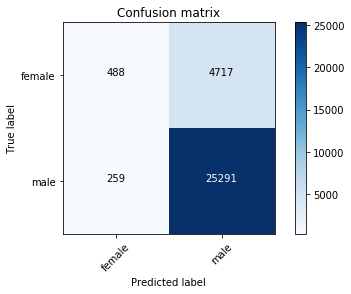

In [37]:
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

___

In [41]:
!df -h

Filesystem            Size  Used Avail Use% Mounted on
/dev/mapper/vg_cn184-lv_root
                      179G  4.3G  166G   3% /
tmpfs                  63G  452K   63G   1% /dev/shm
/dev/sda1             477M   77M  376M  17% /boot
scratchfs1            930T  930T  9.6G 100% /gpfs/scratchfs1
gpfs1                  55T   47T  7.6T  87% /gpfs/gpfs1


In [47]:
import xgboost as xgb
from time import time

In [48]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

In [49]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.9,
#     'eta': 0.1,
    'colsample_bytree': 0.9,
    'max_depth': 18,
    'subsample': 0.9,
#     'alpha': 0.2,
#     'lambda':0.8,
#     'gamma': 0.2,
    'silent': 0,
    'learning_rate':0.01,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':48
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [50]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=300, 
                verbose_eval=20, feval=xg_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

[0]	train-acc:0.851099	test-acc:0.824776
Multiple eval metrics have been passed: 'test-acc' will be used for early stopping.

Will train until test-acc hasn't improved in 300 rounds.
[20]	train-acc:0.860031	test-acc:0.835441
[40]	train-acc:0.861439	test-acc:0.836677
[60]	train-acc:0.86261	test-acc:0.836872
[80]	train-acc:0.863627	test-acc:0.837067
[100]	train-acc:0.864797	test-acc:0.837067
[120]	train-acc:0.865327	test-acc:0.837392
[140]	train-acc:0.866191	test-acc:0.83762
[160]	train-acc:0.866595	test-acc:0.837815
[180]	train-acc:0.867194	test-acc:0.837945
[200]	train-acc:0.867752	test-acc:0.83814
[220]	train-acc:0.868267	test-acc:0.838303
[240]	train-acc:0.86895	test-acc:0.838303
[260]	train-acc:0.869731	test-acc:0.838498
[280]	train-acc:0.870037	test-acc:0.83879
[300]	train-acc:0.870636	test-acc:0.838758
[320]	train-acc:0.870971	test-acc:0.838986
[340]	train-acc:0.871473	test-acc:0.839116
[360]	train-acc:0.871919	test-acc:0.839181
[380]	train-acc:0.872476	test-acc:0.839506
[400]	tra

'!!! used 376.48 s'

accuracy 0.840383677451
statistic
male      29789
female      966
dtype: int64
Confusion matrix, without normalization
[[  631  4574]
 [  335 25215]]


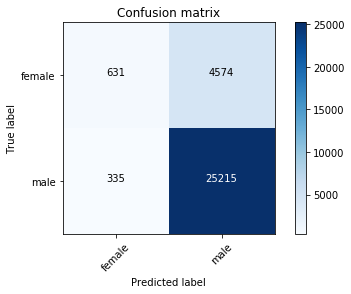

In [51]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

In [52]:
stat = pd.read_csv('desc_stat.csv')
print stat.shape
stat.head()

(903, 2)


,user_id,desc_stat
0,13767750,M
1,699835,M
2,1036584,M
3,554028,M
4,789240,M


In [53]:
X_test.shape

(30755, 887)

In [54]:
desc = X_test[[]].join(stat.set_index('user_id'))['desc_stat'].values
print desc.shape
desc

(30755,)


array([nan, nan, 'M', ..., nan, nan, nan], dtype=object)

In [55]:
prediction = clf.predict(d_test)>.5

In [56]:
final = (pd.Series(desc).fillna('')+pd.Series(prediction).map({1:'M',0:'F'}))\
.str.replace('MM','M').str.replace('FM','F').str.replace('FF','F').str.replace('MF','M')
final.value_counts()

M    29762
F      993
dtype: int64

In [57]:
prediction

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

accuracy 0.840676312795
statistic
M    29762
F      993
dtype: int64
Confusion matrix, without normalization
[[  649  4556]
 [  344 25206]]


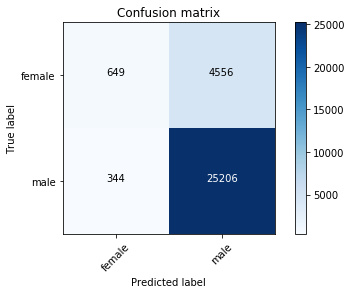

In [58]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), final.map({'M':1,'F':0}))
print 'statistic'
print final.value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),final.map({'M':1,'F':0})), ['female','male'])

#### compare

accuracy 0.840383677451
statistic
male      29789
female      966
dtype: int64
Confusion matrix, without normalization
[[  631  4574]
 [  335 25215]]


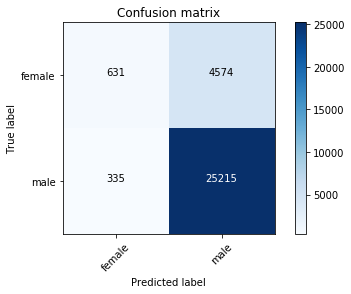

In [59]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])